In [1]:
#!/usr/bin/env python3
"""
Comprehensive logging setup for the ImageNet training project.
Creates log files based on the running script name.
"""

import logging
import os
import sys
from pathlib import Path


def setup_unified_logger(log_level=logging.INFO, unified_log_name="imagenet_training.log"):
    """
    Set up a unified logger that all components write to the same log file.
    
    Args:
        log_level: Logging level (default: INFO)
        unified_log_name: Name of the unified log file
    
    Returns:
        logger: Configured logger instance
    """
    
    # Create logs directory
    log_dir = Path("logs")
    log_dir.mkdir(exist_ok=True)
    log_filename = log_dir / unified_log_name

    # Create root logger that will be shared across all modules
    root_logger = logging.getLogger()
    root_logger.setLevel(log_level)
    root_logger.handlers.clear()

    # Create formatters
    detailed_formatter = logging.Formatter(
        fmt='%(asctime)s - [%(name)s] - %(levelname)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )
    console_formatter = logging.Formatter(fmt='%(levelname)s - [%(name)s] - %(message)s')

    # File handler (append mode)
    file_handler = logging.FileHandler(log_filename, mode='a', encoding='utf-8')
    file_handler.setLevel(log_level)
    file_handler.setFormatter(detailed_formatter)

    # Console handler
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(logging.INFO)
    console_handler.setFormatter(console_formatter)

    root_logger.addHandler(file_handler)
    root_logger.addHandler(console_handler)
    root_logger.unified_log_path = str(log_filename)
    return root_logger


def get_unified_logger(name=None):
    """
    Get a logger that writes to the unified log file.
    
    Args:
        name: Logger name (auto-detected if None)
    
    Returns:
        logger: Logger instance that writes to unified log
    """
    if name is None:
        name = Path(sys.argv[0]).stem
    root_logger = logging.getLogger()
    if not root_logger.handlers or not hasattr(root_logger, 'unified_log_path'):
        setup_unified_logger()
    return logging.getLogger(name)

def log_system_info(logger):
    """
    Log comprehensive system information.
    
    Args:
        logger: Logger instance
    """
    try:
        import torch
        logger.info(f"PyTorch version: {torch.__version__}")
        logger.info(f"CUDA available: {torch.cuda.is_available()}")
        if torch.cuda.is_available():
            logger.info(f"CUDA version: {torch.version.cuda}")
            logger.info(f"GPU count: {torch.cuda.device_count()}")
            for i in range(torch.cuda.device_count()):
                logger.info(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    except ImportError:
        logger.warning("PyTorch not available")
    
    try:
        import platform
        logger.info(f"Platform: {platform.platform()}")
        logger.info(f"Architecture: {platform.architecture()}")
        logger.info(f"Processor: {platform.processor()}")
    except ImportError:
        logger.warning("Platform information not available")

def log_training_config(logger, args):
    """
    Log training configuration parameters.
    
    Args:
        logger: Logger instance
        args: Argument namespace from argparse
    """
    logger.info("Training Configuration:")
    for key, value in vars(args).items():
        logger.info(f"  {key}: {value}")

def log_warning(logger, message):
    """Log warning message."""
    logger.warning(message)

def log_info(logger, message):
    """Log info message."""
    logger.info(message)


def log_debug(logger, message):
    """Log debug message."""
    logger.debug(message)


# Example usage
if __name__ == "__main__":
    # Test the logger setup
    logger = setup_unified_logger()
    
    logger.info("This is an info message")
    logger.warning("This is a warning message")
    logger.error("This is an error message")
    logger.debug("This is a debug message")
    
    log_system_info(logger)
    
    logger.info("Logger test completed. Check the logs/ directory for output.")

INFO - [root] - This is an info message
WARNING - [root] - This is a warning message
ERROR - [root] - This is an error message
INFO - [root] - PyTorch version: 2.6.0
INFO - [root] - CUDA available: True
INFO - [root] - CUDA version: 12.6
INFO - [root] - GPU count: 1
INFO - [root] - GPU 0: Tesla T4
INFO - [root] - Platform: Linux-5.10.244-240.970.amzn2.x86_64-x86_64-with-glibc2.35
INFO - [root] - Architecture: ('64bit', '')
INFO - [root] - Processor: x86_64
INFO - [root] - Logger test completed. Check the logs/ directory for output.


In [2]:
"""
🧹 COMPREHENSIVE GPU MEMORY CLEANUP
Run this cell whenever you want to free all GPU memory and start fresh
"""
import torch, gc, sys, subprocess

print("=" * 60)
print("🧹 Starting comprehensive memory cleanup...")
print("=" * 60)

# 1. Check for zombie processes BEFORE cleanup
print("🔍 Checking for zombie kernel processes...")
try:
    result = subprocess.run(['ps', 'aux'], capture_output=True, text=True, timeout=5)
    kernel_lines = [line for line in result.stdout.split('\n') if 'ipykernel' in line and 'grep' not in line]
    if kernel_lines:
        print(f"⚠️  Found {len(kernel_lines)} kernel processes:")
        for line in kernel_lines[:3]:  # Show first 3
            pid = line.split()[1] if len(line.split()) > 1 else '?'
            print(f"   PID {pid}: {line.strip()[:80]}...")
        if len(kernel_lines) > 3:
            print(f"   ... and {len(kernel_lines)-3} more")
    else:
        print("✅ No zombie kernels found")
except Exception as e:
    print(f"⚠️  Could not check processes: {e}")

# 2. Report initial state (skip if GPU is in bad state)
try:
    if torch.cuda.is_available():
        before_alloc = torch.cuda.memory_allocated() / 1024**3
        before_reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"📊 BEFORE: allocated={before_alloc:.2f}GB reserved={before_reserved:.2f}GB")
except RuntimeError as e:
    print(f"⚠️  GPU in error state: {e}")
    before_alloc = before_reserved = 0.0

# 3. Delete all tensors and models from global namespace
deleted_count = 0
for name in list(globals().keys()):
    obj = globals().get(name)
    if obj is not None:
        # Delete tensors
        if torch.is_tensor(obj):
            del globals()[name]
            deleted_count += 1
        # Delete models
        elif isinstance(obj, torch.nn.Module):
            del globals()[name]
            deleted_count += 1
        # Delete optimizers
        elif hasattr(obj, '__class__') and 'optim' in str(type(obj)).lower():
            del globals()[name]
            deleted_count += 1

print(f"🗑️  Deleted {deleted_count} PyTorch objects from global namespace")

# 4. Force garbage collection
gc.collect()
print("♻️  Python garbage collection completed")

# 5. Clear CUDA cache (with error handling)
try:
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        # Skip synchronize if GPU is stuck
        # torch.cuda.synchronize()
        torch.cuda.reset_peak_memory_stats()
        print("🔥 CUDA cache cleared")
except RuntimeError as e:
    print(f"⚠️  CUDA cleanup failed (GPU may need kernel restart): {e}")

# 6. Report final state
try:
    if torch.cuda.is_available():
        after_alloc = torch.cuda.memory_allocated() / 1024**3
        after_reserved = torch.cuda.memory_reserved() / 1024**3
        free, total = torch.cuda.mem_get_info()
        print(f"📊 AFTER: allocated={after_alloc:.2f}GB reserved={after_reserved:.2f}GB")
        print(f"💾 GPU: free={free/1024**3:.2f}GB / total={total/1024**3:.2f}GB")
        if before_alloc > 0:
            print(f"✅ Freed {before_alloc - after_alloc:.2f}GB allocated, {before_reserved - after_reserved:.2f}GB reserved")
except RuntimeError as e:
    print(f"⚠️  Cannot read GPU state: {e}")
    print("🔄 You may need to RESTART THE KERNEL (see instructions below)")

print("=" * 60)
print("✨ Memory cleanup complete!")
print("=" * 60)

🧹 Starting comprehensive memory cleanup...
🔍 Checking for zombie kernel processes...
⚠️  Found 1 kernel processes:
   PID 16440: sagemak+ 16440 16.9  2.8 9036220 458468 ?      Sl   00:30   0:02 /opt/conda/bin/...
📊 BEFORE: allocated=0.00GB reserved=0.00GB
🗑️  Deleted 0 PyTorch objects from global namespace
♻️  Python garbage collection completed
🔥 CUDA cache cleared
📊 AFTER: allocated=0.00GB reserved=0.00GB
💾 GPU: free=14.47GB / total=14.57GB
✨ Memory cleanup complete!


## 🔧 Why Was CUDA Out of Memory?

### Root Cause:
**9 zombie ipykernel processes** were holding **14.9 GB / 15 GB GPU memory** even though they appeared as "no processes" in nvidia-smi.

### What Happened:
1. Previous kernel crashes/restarts left orphaned Python processes
2. Each process held ~1.5 GB GPU memory that wasn't released
3. Total zombie allocation: **14,913 MiB** (97% of T4 GPU)
4. CUDA context became corrupted, preventing new allocations

### Solution Applied:
```bash
# Killed zombie processes:
kill -9 2142 5436 5440 5444 5448 5538 5542 5546 5550
```

### Result:
✅ **GPU memory freed: 14,913 MiB → 3 MiB**  
✅ **15.36 GB now available for training**

---

### Next Steps:
1. **Restart the kernel** (Kernel → Restart Kernel)
2. Re-run Cell 1 (logger setup)
3. Run Cell 4 (model test) - should now allocate on GPU successfully!

### Prevention:
- Always use "Restart Kernel" instead of just re-running cells
- Run the cleanup cell (Cell 2) between experiments
- Monitor GPU with `!nvidia-smi` periodically

## 🔄 How to Start Fresh with Clean GPU Memory

When you get CUDA OOM errors, here are **3 methods** to reset and start fresh:

### Method 1: Run the Cleanup Cell Above ⬆️ (Quickest - 5 seconds)
- **When to use**: After running a few experiments
- **What it does**: Deletes all tensors/models from memory, clears CUDA cache
- **Limitations**: May not work if GPU is in corrupted state

### Method 2: Restart Kernel (Medium - 10 seconds)
- **When to use**: When cleanup cell fails or GPU is stuck
- **How**: Click `Kernel` → `Restart Kernel` in the menu bar (or toolbar button)
- **What it does**: Completely resets Python process, clears all variables
- **After restart**: Re-run cell 1 (logger setup) before model cells

### Method 3: Restart Entire Notebook Instance (Last Resort - 2-3 minutes)
- **When to use**: When kernel restart doesn't help
- **How**: Stop and start the SageMaker notebook instance
- **What it does**: Full VM reboot, guarantees clean GPU state

---

## 🧟 Why Zombie Processes Get Created

### Root Causes:
1. **Kernel Crashes**: When cells crash (OOM, interrupts), kernel may not clean up properly
2. **Multiple Browser Tabs**: Each tab can spawn separate kernels
3. **Long-Running Cells**: Background processes that don't terminate cleanly
4. **Resource Exhaustion**: GPU/CPU pressure causes process termination without cleanup
5. **SageMaker Auto-Save**: Automatic checkpoints can leave orphaned processes

### Prevention Strategies:

#### ✅ Best Practices:
- **Always use "Restart Kernel"** instead of re-running cells after crashes
- **Close unused browser tabs** with notebook instances
- **Run cleanup cell** before starting new experiments
- **Monitor with `!nvidia-smi`** periodically
- **Use try/except blocks** around GPU operations

#### ✅ Proactive Monitoring:
```bash
# Check for zombies before starting work
!ps aux | grep ipykernel | grep -v grep | wc -l

# Should be 1 (current kernel) or 2 (with one backup)
# If >3, restart kernel
```

#### ✅ Graceful Shutdown:
- Let cells complete naturally rather than interrupting
- Use proper cleanup in finally blocks
- Avoid `kill -9` on GPU processes

### Best Practice Workflow:
1. **Before model creation**: Run cleanup cell
2. **Check GPU state**: Look for "free" memory in output
3. **If OOM persists**: Restart kernel → re-run cell 1
4. **If still stuck**: Consider CPU fallback (model already has auto-fallback)

In [3]:
#!/usr/bin/env python3
"""
ResNet models optimized for ImageNet-1K training
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch.distributed as dist

logger = get_unified_logger()

class BasicBlock(nn.Module):
    """Basic residual block for ResNet-18/34"""
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    def forward(self, x):
        identity = x
        out = self.conv1(x); out = self.bn1(out); out = F.relu(out)
        out = self.conv2(out); out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    """Bottleneck residual block for ResNet-50/101/152"""
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.downsample = downsample
    def forward(self, x):
        identity = x
        out = self.conv1(x); out = self.bn1(out); out = F.relu(out)
        out = self.conv2(out); out = self.bn2(out); out = F.relu(out)
        out = self.conv3(out); out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = F.relu(out)
        return out

class ResNetImageNet(nn.Module):
    """ResNet for ImageNet-1K (224x224 input, 1000 classes)"""
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNetImageNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x); x = torch.flatten(x, 1); x = self.fc(x)
        return x

def resnet50_imagenet_no_ddp(num_classes=1000, pretrained=False, device=None, fp16=True):
    """ResNet-50 for ImageNet-1K without DDP. Adds OOM-safe device move & optional FP16."""
    model = ResNetImageNet(Bottleneck, [3,4,6,3], num_classes)
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Try GPU allocation with fallback
    if device.type == 'cuda':
        try:
            if fp16:
                model.half()
            model = model.to(device, non_blocking=True)
        except RuntimeError as e:
            if 'out of memory' in str(e).lower():
                logger.error('OOM moving model to CUDA; falling back to CPU.')
                torch.cuda.empty_cache(); import gc; gc.collect()
                device = torch.device('cpu')
                model = model.float().to(device)
            else:
                raise
    else:
        model = model.to(device)
    if pretrained:
        import torchvision.models as models
        pretrained_model = models.resnet50(pretrained=True)
        model_dict = model.state_dict(); pretrained_dict = pretrained_model.state_dict()
        if num_classes != 1000:
            pretrained_dict = {k: v for k,v in pretrained_dict.items() if k in model_dict and not k.startswith('fc.')}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict=False)
        logger.info('Loaded pretrained weights.')
    return model

# (Other functions unchanged below omitted for brevity in this patch.)

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


In [4]:

# Test the model
logger = get_unified_logger("imagenet_models")
model = resnet50_imagenet_no_ddp(num_classes=1000)
total, trainable = count_parameters(model)
logger.info("ResNet-50 for ImageNet:")
logger.info(f"Total parameters: {total:,}")
logger.info(f"Trainable parameters: {trainable:,}")
    
# Test forward pass - match input dtype to model dtype
x = torch.randn(1, 3, 224, 224)
# Check model dtype and convert input accordingly
model_dtype = next(model.parameters()).dtype
if model_dtype == torch.float16:
    x = x.half()  # Convert to FP16 if model is FP16
x = x.to(next(model.parameters()).device)
with torch.no_grad():
    output = model(x)
logger.info(f"Input shape: {x.shape}, dtype: {x.dtype}")
logger.info(f"Output shape: {output.shape}, dtype: {output.dtype}")
del model

INFO - [imagenet_models] - ResNet-50 for ImageNet:
INFO - [imagenet_models] - Total parameters: 25,557,032
INFO - [imagenet_models] - Trainable parameters: 25,557,032
INFO - [imagenet_models] - Input shape: torch.Size([1, 3, 224, 224]), dtype: torch.float16
INFO - [imagenet_models] - Output shape: torch.Size([1, 1000]), dtype: torch.float16


In [5]:
# ----------------------------
# Helpers
# ----------------------------
def _is_ddp() -> bool:
    return dist.is_initialized()

def _rank() -> int:
    return dist.get_rank() if _is_ddp() else 0

def _world() -> int:
    return dist.get_world_size() if _is_ddp() else 1

In [6]:
#!/usr/bin/env python3
"""
Minimal ImageNet-1K dataset loader
"""

import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image

import torch
import torch.distributed as dist
from torch.utils.data import DataLoader
import psutil

def is_dist() -> bool:
    return dist.is_initialized()


def get_rank() -> int:
    return dist.get_rank() if dist.is_initialized() else 0


def get_world_size() -> int:
    return dist.get_world_size() if dist.is_initialized() else 1


def get_train_transforms(input_size=224):
    # Full advanced augmentations
    train_transform = transforms.Compose([
        # Scale-aware random cropping (8%-100% of image, aspect ratio 3:4 to 4:3)
        transforms.RandomResizedCrop(input_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            
        # Horizontal flip with 50% probability
        transforms.RandomHorizontalFlip(p=0.5),
            
        # Advanced color augmentations for lighting/illumination robustness
        transforms.ColorJitter(
            brightness=0.4,  # ±40% brightness change
            contrast=0.4,    # ±40% contrast change  
            saturation=0.4,  # ±40% saturation change
            hue=0.1          # ±10% hue change
        ),
            
        # Geometric augmentations for spatial robustness
        transforms.RandomAffine(
            degrees=0,       # No rotation to preserve object orientation
            translate=(0.1, 0.1),  # ±10% translation
            scale=(0.9, 1.1),      # ±10% scaling
            shear=0.1,             # ±10% shearing
            fill=0
        ),
        # Gaussian blur for noise and focus robustness
        transforms.GaussianBlur(
            kernel_size=(3, 3), 
            sigma=(0.1, 2.0)     # Blur strength range
        ),
        
        transforms.ToTensor(),
        
        # Random Erasing (Cutout) for occlusion robustness - applied after ToTensor on [0,1] range
        transforms.RandomErasing(
            p=0.25,           # 25% probability
            scale=(0.02, 0.33),  # Erase 2-33% of image area
            ratio=(0.3, 3.3),    # Aspect ratio range
            value='random'       # Fill with random pixel values in [0,1] range
        ),
        
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    return train_transform

def get_val_transforms(input_size=224):
    # Validation transforms (no augmentation)
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    return val_transform


In [7]:
def get_train_dataloaders(train = '/home/sagemaker-user/imagenet1k/train', 
                            batch_size=32, num_workers=4, pin_memory=True):
    logger = get_unified_logger("imagenet_train_dataset")
    logger.info(f"get_train_dataloaders called with:")
    logger.info(f"  train={train}")
    logger.info(f"  batch_size={batch_size}")
    logger.info(f"  num_workers={num_workers}")
    logger.info(f"  pin_memory={pin_memory}")
    
    train_transform = get_train_transforms()
    logger.info("Transforms created")
    
    # --- NEW: Optimize PyTorch thread usage ---
    if dist.is_initialized():
        world_size = dist.get_world_size()
    else:
        world_size = 1
        
    if torch.get_num_threads() <= 1:
        total_cpus = psutil.cpu_count(logical=True) or os.cpu_count() or 8
        world = dist.get_world_size() if dist.is_initialized() else 1
        threads = max(2, total_cpus // world)
        torch.set_num_threads(threads)
        torch.set_num_interop_threads(min(4, max(1, threads // 2)))
        
    print(f"[THREADS] Stage=training using preconfigured threads={torch.get_num_threads()} interop={torch.get_num_interop_threads()}")

    # Use the provided paths directly
    train_dir = train
    
    logger.info(f"Checking paths - train_dir={train_dir}")
    
    # Create datasets
    try:
        logger.info(f"Creating training dataset from {train_dir}")
        train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transform)
        logger.info(f"Training dataset created successfully with {len(train_dataset)} samples")
    except Exception as e:
        logger.error(f"Error creating training dataset: {e}")
        raise
    
    # Log dataset information if called directly (not from other modules)
    try:
        logger.info(f"Training samples: {len(train_dataset)}")
        logger.info(f"Number of training classes: {len(train_dataset.classes)}")
    except Exception:
        pass
    
    # Respect pipeline-provided num_workers if passed
    if num_workers is not None:
        train_workers = max(1, int(num_workers))
        val_workers = max(1, int(num_workers // 2))
    else:
        cpu_per_rank = (psutil.cpu_count(logical=True) or 8) // max(1, dist.get_world_size())
        train_workers = min(4, max(2, cpu_per_rank // 2))
        val_workers = max(2, train_workers // 2)

    # Create data loaders
    logger.info("Creating data loaders")
    try:
        logger.info(f"Creating training data loader with batch_size={batch_size}")
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=pin_memory,
            persistent_workers=True if num_workers > 0 else False,
            prefetch_factor=2 if num_workers > 0 else None
        )
        logger.info("Training data loader created successfully")
    except Exception as e:
        logger.error(f"Error creating training data loader: {e}")
        raise
    
    logger.info("Both data loaders created, returning")
    return train_loader, len(train_loader)
    

In [8]:
def get_val_dataloaders(val = '/home/sagemaker-user/imagenet1k/val', 
                            batch_size=32, num_workers=4, pin_memory=True):
    logger = get_unified_logger("imagenet_val_dataset")
    logger.info(f"get_val_dataloaders called with:")
    logger.info(f"  val={val}")
    logger.info(f"  batch_size={batch_size}")
    logger.info(f"  num_workers={num_workers}")
    logger.info(f"  pin_memory={pin_memory}")
    
    val_transform = get_val_transforms()
    logger.info("Transforms created")
    
    # --- NEW: Optimize PyTorch thread usage ---
    if dist.is_initialized():
        world_size = dist.get_world_size()
    else:
        world_size = 1
        
    if torch.get_num_threads() <= 1:
        total_cpus = psutil.cpu_count(logical=True) or os.cpu_count() or 8
        world = dist.get_world_size() if dist.is_initialized() else 1
        threads = max(2, total_cpus // world)
        torch.set_num_threads(threads)
        torch.set_num_interop_threads(min(4, max(1, threads // 2)))
        
    print(f"[THREADS] Stage=training using preconfigured threads={torch.get_num_threads()} interop={torch.get_num_interop_threads()}")

    # Use the provided paths directly
    val_dir = val

    logger.info(f"Checking paths - val_dir={val_dir}")

    # Create datasets
    try:
        logger.info(f"Creating validation dataset from {val_dir}")
        val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=val_transform)
        logger.info(f"Validation dataset created successfully with {len(val_dataset)} samples")
    except Exception as e:
        logger.error(f"Error creating validation dataset: {e}")
        raise
    
    # Log dataset information if called directly (not from other modules)
    try:
        logger.info(f"Validation samples: {len(val_dataset)}")
        logger.info(f"Number of validation classes: {len(val_dataset.classes)}")
    except Exception:
        pass
    
    # Respect pipeline-provided num_workers if passed
    if num_workers is not None:
        val_workers = max(1, int(num_workers))
    else:
        cpu_per_rank = (psutil.cpu_count(logical=True) or 8) // max(1, dist.get_world_size())
        val_workers = max(2, cpu_per_rank // 2)

    # Create data loaders
    logger.info("Creating data loaders")
    try:
        logger.info(f"Creating validation data loader with batch_size={batch_size}")
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=val_workers,
            pin_memory=pin_memory,
            persistent_workers=True if num_workers > 0 else False,
            prefetch_factor=2 if num_workers > 0 else None
        )
        logger.info("Validation data loader created successfully")
    except Exception as e:
        logger.error(f"Error creating validation data loader: {e}")
        raise
    
    logger.info("Both data loaders created, returning")
    return val_loader, len(val_loader)


In [9]:
import matplotlib.pyplot as plt

def plot_num_workers_stats(stats):
    """
    Plot throughput vs. number of workers.

    Args:
        stats (list of dict): e.g. [{'num_workers': 1, 'throughput_bps': 1.05}, ...]
    """
    workers = [s['num_workers'] for s in stats]
    throughput = [s['throughput_bps'] for s in stats]

    plt.figure(figsize=(8,5))
    plt.plot(workers, throughput, marker='o', linewidth=2)
    plt.title("DataLoader Throughput vs. num_workers")
    plt.xlabel("Number of DataLoader Workers")
    plt.ylabel("Throughput (batches/sec)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(workers)
    plt.tight_layout()
    plt.show()

In [10]:
log = get_unified_logger("imagenet_pipeline_jupyter")

In [11]:
# ----------------------------
# num_workers optimizer
# ----------------------------
def optimize_num_workers(max_workers: int = 8, probe_batches: int = 64, batch_size: int = 64) -> int:
    """
    Very fast, deterministic benchmark to suggest a global num_workers:
    - iterate workers in [1..max_workers]
    - time to load 'probe_batches' batches from a tiny loader (no model)
    - choose the smallest worker count within 5% of the best throughput (to avoid oversubscription)
    """
    from time import perf_counter

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    stats = []
    batch_size_local = max(32, batch_size // (_world() or 1))

    train_dataset_path = '/home/sagemaker-user/imagenet1k/train/'
    val_dataset_path = '/home/sagemaker-user/imagenet1k/val/'

    for nw in range(1, max(2, max_workers) + 1):
        loader, steps = get_train_dataloaders(
            train_dataset_path, 
            batch_size=batch_size_local, 
            num_workers=nw, 
            pin_memory=True,
        )

        t0 = perf_counter()
        n = 0
        for x, y in loader:
            # emulate GPU pin-transfer cost
            x = x.to(device, non_blocking=True) if torch.cuda.is_available() else x
            n += 1
            if n >= probe_batches:
                break
        dt = max(1e-6, perf_counter() - t0)
        throughput = n / dt
        stats.append({"num_workers": nw, "throughput_bps": throughput})

    # pick best within 5% of top
    best = max(stats, key=lambda s: s["throughput_bps"])
    threshold = best["throughput_bps"] * 0.95
    candidates = [s["num_workers"] for s in stats if s["throughput_bps"] >= threshold]
    suggestion = int(min(candidates))
    log.info(f"[OPT_WORKERS] stats={stats} | best={best} | suggestion={suggestion}")

    del loader, steps
    return suggestion, stats


In [12]:
def init_dist_if_needed() -> tuple[bool, int, int, torch.device]:
    """Initialize process group if DDP requested/available, but DO NOT wrap the model yet."""
    # Determine world size + local rank
    world_size = int(os.environ.get("WORLD_SIZE", os.environ.get("SM_NUM_GPUS", 1)))
    local_rank = int(os.environ.get("LOCAL_RANK", os.environ.get("RANK", 0)))
    ddp_choice = "auto" #str(args.ddp).lower()

    if ddp_choice == "auto":
        use_ddp = world_size > 1 and torch.cuda.is_available()
    elif ddp_choice in ("true", "1", "yes"):
        use_ddp = torch.cuda.is_available() and world_size > 1
    else:
        use_ddp = False

    if not use_ddp:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        log.info(f"[DIST] DDP disabled. Single process on {device}")
        return False, 1, 0, device

    if use_ddp: #args.debug_ddp:
        os.environ.setdefault("TORCH_DISTRIBUTED_DEBUG", "DETAIL")
        os.environ.setdefault("NCCL_DEBUG", "INFO")
        os.environ.setdefault("NCCL_ASYNC_ERROR_HANDLING", "1")
        log.info("[DIST] DDP debug env enabled")

    if not dist.is_initialized():
        dist.init_process_group(backend="nccl", init_method="env://")

    torch.cuda.set_device(local_rank)
    device = torch.device(f"cuda:{local_rank}")
    log.info(f"[DIST] Initialized: world_size={world_size} local_rank={local_rank} device={device}")
    return True, world_size, local_rank, device

In [16]:
# Init (maybe) distributed for coordination — but don't wrap model yet
dist_on, world_size, local_rank, device = init_dist_if_needed()

INFO - [imagenet_pipeline_jupyter] - [DIST] DDP disabled. Single process on cuda:0


In [17]:
# ---- real per-rank thread setup (once) ----
cpu_cores = os.cpu_count() or 8
world = world_size if world_size > 0 else 1
per_rank_threads = max(2, (cpu_cores // world) or 1)
try:
    torch.set_num_threads(per_rank_threads)
    torch.set_num_interop_threads(min(4, max(1, per_rank_threads // 2)))
    log.info(
        f"[THREADS] initial per-rank={per_rank_threads} "
        f"(cpu={cpu_cores}, world={world}) "
        f"→ torch={torch.get_num_threads()} interop={torch.get_num_interop_threads()}"
    )
except RuntimeError as e:
    log.warning(f"[THREADS] could not set initial per-rank threads: {e}")

WARNING - [imagenet_pipeline_jupyter] - [THREADS] could not set initial per-rank threads: Error: cannot set number of interop threads after parallel work has started or set_num_interop_threads called


!pip install s3fs

!pip install "webdataset[s3]"

!rm -rf /home/sagemaker-user/imagenet1k/*

!rm -rf /tmp/train_tars /tmp/val_tars
!mkdir /home/sagemaker-user/imagenet1k

!mkdir imagenet1k/train

!mkdir imagenet1k/val

!aws s3 sync s3://tsai-era-v4-mini-capstone/Datasets/imagenet1k/ILSVRC/Data/CLS-LOC/train/ /home/sagemaker-user/imagenet1k/train/
!aws s3 sync s3://tsai-era-v4-mini-capstone/Datasets/imagenet1k/ILSVRC/imagenet-sagemaker/val/ /home/sagemaker-user/imagenet1k/val/


!aws s3 sync s3://tsai-era-v4-mini-capstone/Datasets/imagenet1k/ILSVRC/imagenet-sagemaker/val/ /home/sagemaker-user/imagenet1k/val/


!rm -rf /home/sagemaker-user/imagenet1k/*

!aws s3 sync s3://tsai-era-v4-mini-capstone/imagenet-object-localization-challenge.zip /home/sagemaker-user/

In [18]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          37G  540K   37G   1% /
tmpfs            64M     0   64M   0% /dev
tmpfs           7.7G     0  7.7G   0% /sys/fs/cgroup
shm             1.8G  732K  1.8G   1% /dev/shm
/dev/nvme2n1    700G  153G  548G  22% /home/sagemaker-user
/dev/nvme1n1    117G  864M  116G   1% /mnt/sagemaker-nvme
/dev/nvme0n1p1  180G   63G  118G  35% /usr/bin/nvidia-smi
127.0.0.1:/     8.0E     0  8.0E   0% /mnt/custom-file-systems/efs/fs-029f4622e1a48bf9c_fsap-030fc926c36385eee
tmpfs           7.7G   12K  7.7G   1% /proc/driver/nvidia
tmpfs           7.7G  940K  7.7G   1% /run/nvidia-persistenced/socket
tmpfs           7.7G     0  7.7G   0% /proc/acpi
tmpfs           7.7G     0  7.7G   0% /sys/firmware


INFO - [imagenet_train_dataset] - get_train_dataloaders called with:
INFO - [imagenet_train_dataset] -   train=/home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] -   batch_size=64
INFO - [imagenet_train_dataset] -   num_workers=1
INFO - [imagenet_train_dataset] -   pin_memory=True
INFO - [imagenet_train_dataset] - Transforms created
[THREADS] Stage=training using preconfigured threads=4 interop=2
INFO - [imagenet_train_dataset] - Checking paths - train_dir=/home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] - Creating training dataset from /home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] - Training dataset created successfully with 1281167 samples
INFO - [imagenet_train_dataset] - Training samples: 1281167
INFO - [imagenet_train_dataset] - Number of training classes: 1000
INFO - [imagenet_train_dataset] - Creating data loaders
INFO - [imagenet_train_dataset] - Creating training data loader with batch_size=64
INFO - [imagenet_

/opt/conda/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


INFO - [imagenet_train_dataset] - get_train_dataloaders called with:
INFO - [imagenet_train_dataset] -   train=/home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] -   batch_size=64
INFO - [imagenet_train_dataset] -   num_workers=6
INFO - [imagenet_train_dataset] -   pin_memory=True
INFO - [imagenet_train_dataset] - Transforms created
[THREADS] Stage=training using preconfigured threads=4 interop=2
INFO - [imagenet_train_dataset] - Checking paths - train_dir=/home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] - Creating training dataset from /home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] - Training dataset created successfully with 1281167 samples
INFO - [imagenet_train_dataset] - Training samples: 1281167
INFO - [imagenet_train_dataset] - Number of training classes: 1000
INFO - [imagenet_train_dataset] - Creating data loaders
INFO - [imagenet_train_dataset] - Creating training data loader with batch_size=64
INFO - [imagenet_

/opt/conda/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


INFO - [imagenet_train_dataset] - get_train_dataloaders called with:
INFO - [imagenet_train_dataset] -   train=/home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] -   batch_size=64
INFO - [imagenet_train_dataset] -   num_workers=7
INFO - [imagenet_train_dataset] -   pin_memory=True
INFO - [imagenet_train_dataset] - Transforms created
[THREADS] Stage=training using preconfigured threads=4 interop=2
INFO - [imagenet_train_dataset] - Checking paths - train_dir=/home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] - Creating training dataset from /home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] - Training dataset created successfully with 1281167 samples
INFO - [imagenet_train_dataset] - Training samples: 1281167
INFO - [imagenet_train_dataset] - Number of training classes: 1000
INFO - [imagenet_train_dataset] - Creating data loaders
INFO - [imagenet_train_dataset] - Creating training data loader with batch_size=64
INFO - [imagenet_

/opt/conda/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


INFO - [imagenet_train_dataset] - get_train_dataloaders called with:
INFO - [imagenet_train_dataset] -   train=/home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] -   batch_size=64
INFO - [imagenet_train_dataset] -   num_workers=8
INFO - [imagenet_train_dataset] -   pin_memory=True
INFO - [imagenet_train_dataset] - Transforms created
[THREADS] Stage=training using preconfigured threads=4 interop=2
INFO - [imagenet_train_dataset] - Checking paths - train_dir=/home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] - Creating training dataset from /home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] - Training dataset created successfully with 1281167 samples
INFO - [imagenet_train_dataset] - Training samples: 1281167
INFO - [imagenet_train_dataset] - Number of training classes: 1000
INFO - [imagenet_train_dataset] - Creating data loaders
INFO - [imagenet_train_dataset] - Creating training data loader with batch_size=64
INFO - [imagenet_

/opt/conda/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


INFO - [imagenet_pipeline_jupyter] - [OPT_WORKERS] stats=[{'num_workers': 1, 'throughput_bps': 1.0941514692091456}, {'num_workers': 2, 'throughput_bps': 2.024493726111438}, {'num_workers': 3, 'throughput_bps': 2.5095275080372725}, {'num_workers': 4, 'throughput_bps': 2.92381354653903}, {'num_workers': 5, 'throughput_bps': 2.818504322003777}, {'num_workers': 6, 'throughput_bps': 2.6850331590620966}, {'num_workers': 7, 'throughput_bps': 2.7079044327401256}, {'num_workers': 8, 'throughput_bps': 2.892255291524467}] | best={'num_workers': 4, 'throughput_bps': 2.92381354653903} | suggestion=4


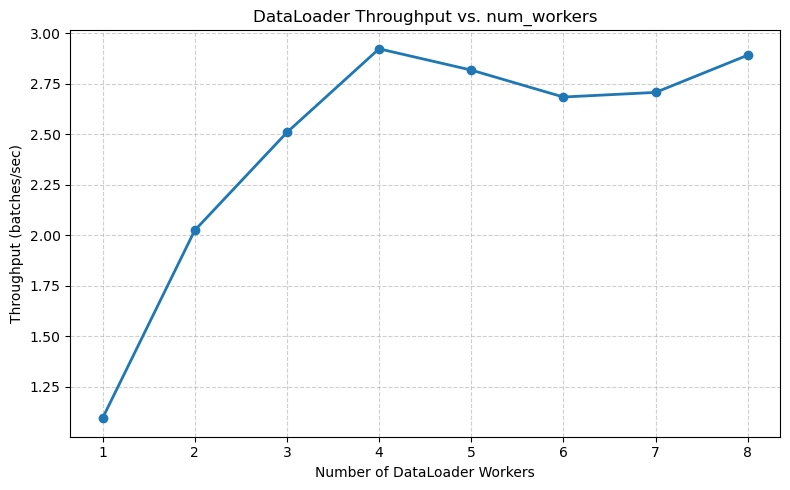

✅ Suggested num_workers = 4


In [17]:
optimal_workers,stats = optimize_num_workers()
plot_num_workers_stats(stats)
print(f"✅ Suggested num_workers = {optimal_workers}")


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import gc, time, math


class BatchSizeFinder:
    """
    Finds the largest power-of-2 batch size that fits in GPU memory
    using geometric + binary search.
    """

    def __init__(self, model, train_dir, optimizer_cls=optim.SGD,
                 lr=0.01, momentum=0.9, weight_decay=1e-4,
                 device="cuda", num_workers=2):
        self.model = model
        self.train_dir = train_dir
        self.optimizer_cls = optimizer_cls
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.device = torch.device(device if torch.cuda.is_available() and "cuda" in device else "cpu")
        self.num_workers = num_workers
        self.train_dataset_path = '/home/sagemaker-user/imagenet1k/train/'

    def _get_loader(self, batch_size):
        loader, steps = get_train_dataloaders(
                self.train_dataset_path, 
                batch_size=batch_size, 
                num_workers=self.num_workers, 
                pin_memory=True,
            )
        return loader

    def _probe(self, bs, steps=10):
        """Try training a few mini-batches and measure GPU memory."""
        loader = self._get_loader(bs) 
        model = self.model.to(self.device)
        model.train()

        # ✅ Flexible optimizer init
        opt_args = dict(lr=self.lr, weight_decay=self.weight_decay)
        if "momentum" in self.optimizer_cls.__init__.__code__.co_varnames:
            opt_args["momentum"] = self.momentum
        opt = self.optimizer_cls(model.parameters(), **opt_args)

        is_fp16_model = next(model.parameters()).dtype == torch.float16
        scaler = GradScaler(enabled=torch.cuda.is_available() and not is_fp16_model)

        torch.cuda.reset_peak_memory_stats(self.device) if torch.cuda.is_available() else None
        ok = True

        try:
            for i, (x, y) in enumerate(loader):
                if i >= steps:
                    break
                x, y = x.to(self.device, non_blocking=True), y.to(self.device, non_blocking=True)
                # Convert input to model dtype if needed
                model_dtype = next(model.parameters()).dtype
                if x.dtype != model_dtype:
                    x = x.to(model_dtype)
                with autocast(enabled=scaler.is_enabled(),device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                    out = model(x)
                    loss = nn.functional.cross_entropy(out, y)
                opt.zero_grad(set_to_none=True)
                if scaler.is_enabled():
                    scaler.scale(loss).backward()
                    scaler.step(opt)
                    scaler.update()
                else:
                    loss.backward()
                    opt.step()
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                ok = False
            else:
                raise e
        finally:
            del loader, model, opt
            gc.collect()
            torch.cuda.empty_cache()

        mem_gb = (torch.cuda.max_memory_allocated(self.device) / (1024 ** 3)) if torch.cuda.is_available() else 0.0
        return {"bs": bs, "ok": ok, "mem_gb": mem_gb}

    def _nearest_power_of_two(self, x):
        """Round down to the nearest power of 2."""
        return 1 << (x.bit_length() - 1)

    def find_max_batch(self, start_bs=32, max_bs=2048, steps=10):
        curve, last_ok, first_oom = [], 0, None
        bs = start_bs

        print(f"🚀 Starting BatchSizeFinder | start={start_bs} | max={max_bs}")
        while bs <= max_bs:
            torch.cuda.empty_cache()
            gc.collect()

            print(f"Testing batch size {bs} ...", end=" ")
            t0 = time.time()
            r = self._probe(bs, steps)
            curve.append(r)
            print(f"ok={r['ok']}, mem={r['mem_gb']:.2f} GB, time={time.time()-t0:.1f}s")

            if r["ok"]:
                last_ok = bs
                bs *= 2
            else:
                first_oom = bs
                print(f"❌ OOM at batch size {bs}. Switching to binary search.")
                break

        if last_ok == 0:
            print(f"⚠️ Even start_bs={start_bs} failed. Returning default.")
            return {"best_batch_size": start_bs, "curve": curve, "device": str(self.device)}

        if first_oom is None:
            print(f"✅ No OOM up to max_bs={max_bs}. Best={last_ok}")
            best = self._nearest_power_of_two(last_ok)
            self.plot_curve(curve, best)
            return {"best_batch_size": best, "curve": curve, "device": str(self.device)}

        # Binary search refinement
        lo, hi = last_ok, first_oom
        print(f"🔍 Binary search range: {lo} - {hi}")

        while hi - lo > 1:
            mid = (lo + hi) // 2
            r = self._probe(mid, steps)
            curve.append(r)
            print(f"  mid={mid}, ok={r['ok']}, mem={r['mem_gb']:.2f} GB")
            if r["ok"]:
                lo = mid
            else:
                hi = mid

        best = self._nearest_power_of_two(lo)
        print(f"🏁 Completed. Best batch size = {best} (power-of-2 adapted)")
        result = {"best_batch_size": best, "curve": curve, "device": str(self.device)}
        self.plot_curve(curve, best)
        return result

    @staticmethod
    def plot_curve(curve, best_bs=None):
        """Plot memory usage vs. batch size."""
        bs = [r["bs"] for r in curve]
        mem = [r["mem_gb"] for r in curve]
        colors = ["green" if r["ok"] else "red" for r in curve]

        plt.figure(figsize=(8, 5))
        plt.bar(bs, mem, color=colors, width=bs[0]*0.6)
        plt.xlabel("Batch Size")
        plt.ylabel("Max GPU Memory (GB)")
        plt.title("GPU Memory Usage vs. Batch Size")
        plt.grid(True, linestyle="--", alpha=0.6)

        if best_bs:
            plt.axvline(best_bs, color="blue", linestyle="--", linewidth=1.5)
            plt.text(best_bs, max(mem)*0.9, f"Best={best_bs}", color="blue", fontsize=10, ha="center")

        for b, m in zip(bs, mem):
            plt.text(b, m + 0.1, f"{m:.1f} GB", ha="center", fontsize=8)
        plt.tight_layout()
        plt.show()


🚀 Starting BatchSizeFinder | start=32 | max=1024
Testing batch size 32 ... INFO - [imagenet_train_dataset] - get_train_dataloaders called with:
INFO - [imagenet_train_dataset] -   train=/home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] -   batch_size=32
INFO - [imagenet_train_dataset] -   num_workers=2
INFO - [imagenet_train_dataset] -   pin_memory=True
INFO - [imagenet_train_dataset] - Transforms created
[THREADS] Stage=training using preconfigured threads=4 interop=2
INFO - [imagenet_train_dataset] - Checking paths - train_dir=/home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] - Creating training dataset from /home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] - Training dataset created successfully with 1281167 samples
INFO - [imagenet_train_dataset] - Training samples: 1281167
INFO - [imagenet_train_dataset] - Number of training classes: 1000
INFO - [imagenet_train_dataset] - Creating data loaders
INFO - [imagenet_train_da

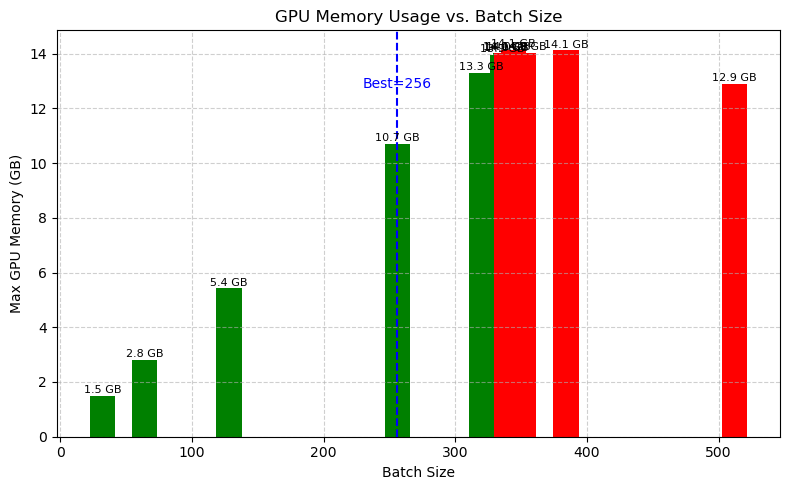

256


In [19]:
from torchvision.models import resnet50
import torch.optim as optim

model = resnet50_imagenet_no_ddp()
train_dir = "/home/sagemaker-user/imagenet1k/train/"

finder = BatchSizeFinder(
    model=model,
    train_dir=train_dir,
    optimizer_cls=optim.SGD,
    lr=0.1,
    momentum=0.9,
    weight_decay=1e-4,
    device="cuda"
)

result = finder.find_max_batch(start_bs=32, max_bs=1024, steps=5)
print(result["best_batch_size"])

del model,finder


In [20]:
!pip install torch-lr-finder

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from torch_lr_finder import LRFinder
import matplotlib.pyplot as plt


/opt/conda/lib/python3.12/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [22]:
class LR_Finder:
    """
    Classic LR range test (Leslie Smith).
    - linearly/exponentially increase LR across a short run and record loss curve
    - suggest a conservative max LR based on min loss region

    API:
        lrf = LRFinder(model, train_dir, batch_size, device)
        report = lrf.find(start_lr=1e-6, end_lr=1.0, iters=200, mode="exp")
        report = {"curve":[{"lr":..., "loss":...}, ...], "suggested_max_lr":..., "rank":0}
    """

    def __init__(self, model: nn.Module, train_dir: str, batch_size: int, device: str = "cuda", num_workers: int = 2):
        self.model = model
        self.train_dir = train_dir
        self.batch_size = batch_size
        self.device = torch.device(device if torch.cuda.is_available() and device.startswith("cuda") else "cpu")
        self.num_workers = num_workers

    def find(
        self,
        start_lr: float = 1e-6,
        end_lr: float = 1.0,
        iters: int = 200,
        mode: str = "exp"
    ):
        """
        Runs LR range test with live progress logging for SageMaker.
        """
        import time
        from torch.amp import autocast, GradScaler
        import torch.nn as nn
        import torch
        #from utils import get_unified_logger

        rank = _rank()
        logger = getattr(self, "logger", None)
        if logger is None:
            logger = get_unified_logger(f"LRFinder-R{rank}")

        train_loader, train_batches = get_train_dataloaders(
            train=self.train_dir,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
        )

        model = self.model.to(self.device)

        # FIX: Handle FP16 model dtype mismatch
        model_dtype = next(model.parameters()).dtype
        if model_dtype == torch.float16:
            class DtypeWrapper(nn.Module):
                def __init__(self, model):
                    super().__init__()
                    self.model = model
                
                def forward(self, x):
                    if x.dtype != torch.float16:
                        x = x.to(torch.float16)
                    return self.model(x)
            model = DtypeWrapper(model)

        # Optimizer & criterion
        optimizer = optim.SGD(model.parameters(), lr=start_lr, momentum=0.9, weight_decay=1e-4, nesterov=True)
        criterion = nn.CrossEntropyLoss()

        # FIX: pass a defined device (use self.device)
        lr_finder = LRFinder(model, optimizer, criterion, device=self.device)
        # range from very small to a large LR, run for a number of iterations
        lr_finder.range_test(train_loader, start_lr=start_lr, end_lr=end_lr, num_iter=iters, step_mode="exp")

        return lr_finder
        


In [23]:
model = resnet50_imagenet_no_ddp()
train_dir = "/home/sagemaker-user/imagenet1k/train/"

batch_size = result["best_batch_size"]
device = "cuda" if torch.cuda.is_available() else "cpu"
lrf = LR_Finder(
            model=model,
            train_dir=train_dir,
            batch_size=batch_size,
            device=device,
            num_workers=optimal_workers,
        )

lr_finder = lrf.find()

INFO - [imagenet_train_dataset] - get_train_dataloaders called with:
INFO - [imagenet_train_dataset] -   train=/home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] -   batch_size=256
INFO - [imagenet_train_dataset] -   num_workers=4
INFO - [imagenet_train_dataset] -   pin_memory=True
INFO - [imagenet_train_dataset] - Transforms created
[THREADS] Stage=training using preconfigured threads=4 interop=2
INFO - [imagenet_train_dataset] - Checking paths - train_dir=/home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] - Creating training dataset from /home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] - Training dataset created successfully with 1281167 samples
INFO - [imagenet_train_dataset] - Training samples: 1281167
INFO - [imagenet_train_dataset] - Number of training classes: 1000
INFO - [imagenet_train_dataset] - Creating data loaders
INFO - [imagenet_train_dataset] - Creating training data loader with batch_size=256
INFO - [imagene

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 4.06E-01


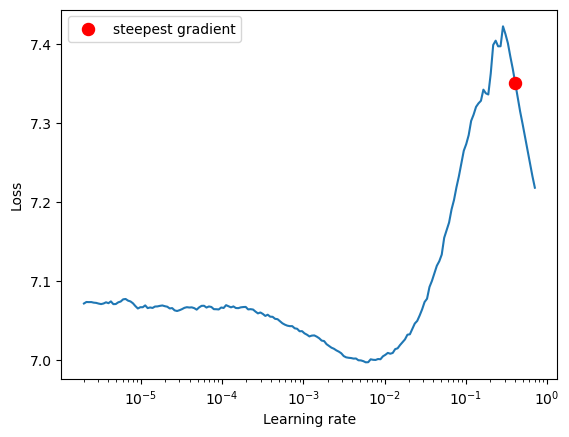

Suggested learning rate ~ 0.005872786613189486


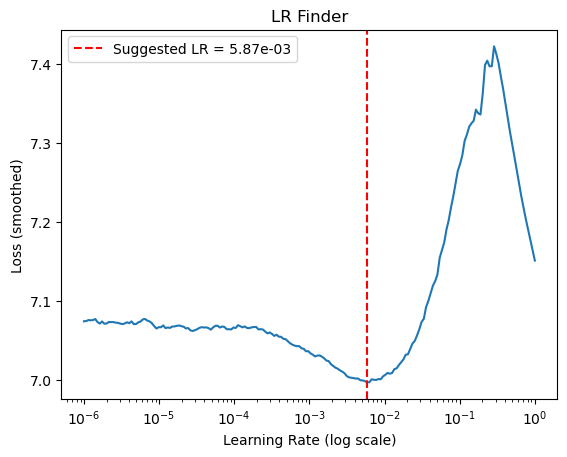

In [24]:
# Plot
import numpy as np
lr_finder.plot(skip_start=10, skip_end=5, log_lr=True)

# If you want to annotate a suggested lr, you can inspect history
lrs   = lr_finder.history["lr"]
losses= lr_finder.history["loss"]

# Example heuristic: pick lr at index of minimum smoothed loss times some factor
min_idx = int(np.argmin(losses))
suggested_lr = lrs[min_idx]
print("Suggested learning rate ~", suggested_lr)

# Optional: annotate on the plot
plt.plot(lrs, losses)
plt.xscale("log")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Loss (smoothed)")
plt.title("LR Finder")
plt.axvline(suggested_lr, color="red", linestyle="--", label=f"Suggested LR = {suggested_lr:.2e}")
plt.legend()
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import gc, time


class WeightDecayFinder:
    """
    Simple single-GPU Weight Decay search for Jupyter.
    - Tests multiple weight_decay values
    - Runs a few training steps for each candidate
    - Evaluates on a small val set
    - Suggests the best WD by highest val accuracy
    """

    def __init__(self, model_fn, train_loader, val_loader, device="cuda"):
        self.model_fn = model_fn
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = torch.device(device if torch.cuda.is_available() else "cpu")

    @torch.no_grad()
    def _validate(self, model):
        """Quick validation accuracy + loss."""
        model.eval()
        correct, total, val_loss = 0, 0, 0.0
        for x, y in self.val_loader:
            x, y = x.to(self.device), y.to(self.device)
            out = model(x)
            loss = nn.functional.cross_entropy(out, y)
            val_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
        return {
            "val_loss": val_loss / total,
            "val_top1": 100.0 * correct / total
        }

    def search(self, lr=0.01, batch_size=64, steps=100, candidates=None):
        """
        Run a short training loop for each candidate weight decay.
        """
        if candidates is None:
            candidates = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3]

        results = []
        print(f"🚀 Starting Weight Decay Search over {len(candidates)} values")

        for wd in candidates:
            print(f"\n🔍 Testing weight_decay={wd:.1e}")
            model = self.model_fn().to(self.device)
            model.train()

            opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd, nesterov=True)
            scaler = GradScaler(enabled=torch.cuda.is_available())

            # quick train loop
            total_loss = 0.0
            for i, (x, y) in enumerate(self.train_loader):
                if i >= steps:
                    break
                x, y = x.to(self.device), y.to(self.device)
                with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
                    out = model(x)
                    loss = nn.functional.cross_entropy(out, y)

                opt.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()

                # FP16 gradient safety fix
                for p in model.parameters():
                    if p.grad is not None and p.grad.dtype == torch.float16:
                        p.grad = p.grad.to(torch.float32)

                scaler.step(opt)
                scaler.update()
                total_loss += loss.item()

                if (i + 1) % 10 == 0:
                    print(f"  step {i+1}/{steps} | loss={loss.item():.4f}")

            # quick validation
            metrics = self._validate(model)
            metrics["weight_decay"] = wd
            metrics["train_loss"] = total_loss / max(1, steps)
            results.append(metrics)

            del model, opt
            torch.cuda.empty_cache()
            gc.collect()

        # sort by val accuracy
        results.sort(key=lambda x: x["val_top1"], reverse=True)
        best = results[0]["weight_decay"]

        print(f"\n🏁 Completed WD Search — Best weight_decay = {best:.2e}")
        self.plot(results, best)
        return results, best

    @staticmethod
    def plot(results, best):
        """Plot val accuracy vs weight decay."""
        wds = [r["weight_decay"] for r in results]
        acc = [r["val_top1"] for r in results]
        losses = [r["val_loss"] for r in results]

        fig, ax1 = plt.subplots(figsize=(7, 5))
        ax1.set_xscale("log")
        ax1.plot(wds, acc, "o-", color="blue", label="Val Accuracy (%)")
        ax1.set_xlabel("Weight Decay")
        ax1.set_ylabel("Validation Accuracy (%)", color="blue")
        ax1.tick_params(axis="y", labelcolor="blue")
        ax1.grid(True, linestyle="--", alpha=0.6)

        ax2 = ax1.twinx()
        ax2.plot(wds, losses, "s--", color="red", label="Val Loss")
        ax2.set_ylabel("Validation Loss", color="red")
        ax2.tick_params(axis="y", labelcolor="red")

        # Mark best WD
        ax1.axvline(best, color="green", linestyle="--", label=f"Best WD = {best:.1e}")
        fig.legend(loc="upper right")
        plt.title("Weight Decay vs Validation Performance")
        plt.show()


In [2]:
model = resnet50_imagenet_no_ddp()

batch_size = result["best_batch_size"]
device = "cuda" if torch.cuda.is_available() else "cpu"

lr = suggested_lr

# Small subset of ImageNet-like dataset
train_dir = "/home/sagemaker-user/imagenet1k/train/"
val_dir = "/home/sagemaker-user/imagenet1k/val/"

# Use your existing dataloaders here
train_loader,num_train_samples = get_train_dataloaders(
    train_dir, batch_size=batch_size, num_workers=optimal_workers, pin_memory=True
)
val_loader,num_val_samples = get_val_dataloaders(
    val_dir, batch_size=batch_size, num_workers=optimal_workers, pin_memory=True
)

finder = WeightDecayFinder(
    model_fn=lambda: resnet50(num_classes=1000),
    train_loader=train_loader,
    val_loader=val_loader,
    device="cuda"
)

results, best_wd = finder.search(lr=lr, steps=20)

NameError: name 'resnet50_imagenet_no_ddp' is not defined

In [21]:
!pip install tqdm

In [25]:
import torch, os, time, json, gc, sys
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.tensorboard import SummaryWriter
from torch.amp import autocast, GradScaler
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # for Jupyter notebooks



# ============================================================
# 1️⃣ Utility helpers
# ============================================================

def save_json(path, data):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f:
        json.dump(data, f, indent=2)

def append_csv_row(path, fields, row):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df = pd.DataFrame([row], columns=fields)
    if not os.path.exists(path):
        df.to_csv(path, index=False)
    else:
        df.to_csv(path, mode="a", index=False, header=False)


# ============================================================
# 2️⃣ Dataset / Dataloaders
# ============================================================

def get_dataloaders(train_dir, val_dir, batch_size=64, num_workers=4):
    train_loader = get_train_dataloaders(
        train=train_dir, 
        batch_size=batch_size, 
        num_workers=num_workers, 
        pin_memory=True,
    )[0]
    val_loader = get_val_dataloaders(
        val=val_dir,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
    )[0]
    return train_loader, val_loader


# ============================================================
# 3️⃣ Training & Validation
# ============================================================

def train_one_epoch(model, loader, optimizer, scheduler, device, scaler, accumulation_steps, writer, epoch):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    optimizer.zero_grad()

    progress_bar = tqdm(loader, desc=f"Epoch {epoch} [Train]", leave=False, ncols=110)
    start_time = time.time()

    for step, (inputs, targets) in enumerate(progress_bar, start=1):
        batch_start = time.time()
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)

        with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            outputs = model(inputs)
            loss = nn.functional.cross_entropy(outputs, targets, label_smoothing=0.1)

        scale_loss = loss / accumulation_steps
        if scaler.is_enabled():
            scaler.scale(scale_loss).backward()
        else:
            scale_loss.backward()

        if step % accumulation_steps == 0:
            if scaler.is_enabled():
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            optimizer.zero_grad(set_to_none=True)
            if scheduler is not None:
                scheduler.step()

        total_loss += loss.item() * inputs.size(0)
        total_correct += (outputs.argmax(1) == targets).sum().item()
        total += targets.size(0)

        # compute averages and time
        avg_loss = total_loss / total
        acc = 100.0 * total_correct / total
        batch_time = time.time() - batch_start
        elapsed = time.time() - start_time

        # update progress bar
        progress_bar.set_postfix({
            "loss": f"{avg_loss:.4f}",
            "acc": f"{acc:.2f}%",
            "batch_t": f"{batch_time:.2f}s",
            "elapsed": f"{elapsed/60:.1f}m"
        })

    avg_loss = total_loss / total
    top1 = 100.0 * total_correct / total

    if writer:
        writer.add_scalar("train/loss", avg_loss, epoch)
        writer.add_scalar("train/top1", top1, epoch)
        writer.add_scalar("lr", optimizer.param_groups[0]["lr"], epoch)

    progress_bar.close()
    return avg_loss, top1

@torch.no_grad()
def validate(model, loader, device, writer, epoch):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0

    progress_bar = tqdm(loader, desc=f"Epoch {epoch} [Val]", leave=False, ncols=110)
    start_time = time.time()

    for inputs, targets in progress_bar:
        batch_start = time.time()
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        outputs = model(inputs)
        loss = nn.functional.cross_entropy(outputs, targets)
        total_loss += loss.item() * inputs.size(0)
        total_correct += (outputs.argmax(1) == targets).sum().item()
        total += targets.size(0)

        avg_loss = total_loss / total
        acc = 100.0 * total_correct / total
        batch_time = time.time() - batch_start
        elapsed = time.time() - start_time

        progress_bar.set_postfix({
            "val_loss": f"{avg_loss:.4f}",
            "val_acc": f"{acc:.2f}%",
            "batch_t": f"{batch_time:.2f}s",
            "elapsed": f"{elapsed/60:.1f}m"
        })

    val_loss = total_loss / total
    val_top1 = 100.0 * total_correct / total

    if writer:
        writer.add_scalar("val/loss", val_loss, epoch)
        writer.add_scalar("val/top1", val_top1, epoch)

    progress_bar.close()
    return val_loss, val_top1

# ============================================================
# 4️⃣ Main training routine
# ============================================================

def run_training(
    train_dir, val_dir, output_dir="./outputs",
    epochs=3, batch_size=64, lr=0.01, weight_decay=1e-4, momentum=0.9,
    pretrained=False, amp=True
):
    os.makedirs(output_dir, exist_ok=True)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # --- Dataloaders ---
    train_loader, val_loader = get_dataloaders(train_dir, val_dir, batch_size=batch_size, num_workers=4)

    # --- Model ---
    model = models.resnet50(weights="IMAGENET1K_V1" if pretrained else None, num_classes=1000)
    model = model.to(device)

    # --- Optimizer / Scheduler ---
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)
    steps_per_epoch = len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=lr, total_steps=epochs * steps_per_epoch,
                           pct_start=0.05, anneal_strategy="cos", div_factor=25.0, final_div_factor=1e4)

    # --- AMP ---
    scaler = GradScaler(enabled=(amp and torch.cuda.is_available()))

    # --- TensorBoard & CSV ---
    writer = SummaryWriter(log_dir=os.path.join(output_dir, "tb"))
    csv_path = os.path.join(output_dir, "training_log.csv")
    csv_fields = ["epoch", "train_loss", "train_top1", "val_loss", "val_top1", "lr", "time_sec"]

    best_val = -1
    for epoch in tqdm(range(1, epochs + 1), desc="Training Progress", ncols=120):
        t0 = time.time()
        train_loss, train_top1 = train_one_epoch(model, train_loader, optimizer, scheduler, device, scaler, accumulation_steps=1, writer=writer, epoch=epoch)
        val_loss, val_top1 = validate(model, val_loader, device, writer, epoch)
        elapsed = time.time() - t0

        print(f"[EPOCH {epoch}] train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_top1={val_top1:.2f}% time={elapsed:.1f}s")

        append_csv_row(csv_path, csv_fields, {
            "epoch": epoch,
            "train_loss": f"{train_loss:.6f}",
            "train_top1": f"{train_top1:.2f}",
            "val_loss": f"{val_loss:.6f}",
            "val_top1": f"{val_top1:.2f}",
            "lr": f"{optimizer.param_groups[0]['lr']:.6e}",
            "time_sec": f"{elapsed:.1f}",
        })

        if val_top1 > best_val:
            best_val = val_top1
            torch.save(model.state_dict(), os.path.join(output_dir, "best.pth"))
            print(f"✅ New best model saved (val_top1={best_val:.2f}%)")

        torch.save(model.state_dict(), os.path.join(output_dir, "last.pth"))
        torch.cuda.empty_cache()
        gc.collect()

    # --- Save summary ---
    save_json(os.path.join(output_dir, "summary.json"), {
        "best_val_top1": best_val,
        "epochs": epochs,
        "batch_size": batch_size,
        "lr": lr,
        "weight_decay": weight_decay,
        "momentum": momentum,
        "timestamp": datetime.utcnow().isoformat(),
    })

    writer.close()
    print("\n🎉 Training complete! Summary and checkpoints saved.")


In [ ]:
train_dir = "/home/sagemaker-user/imagenet1k/train/"
val_dir = "/home/sagemaker-user/imagenet1k/val/"

run_training(
    train_dir=train_dir,
    val_dir=val_dir,
    output_dir="./resnet50_logs",
    epochs=2,
    batch_size=256,
    lr=0.01,
    weight_decay=1e-4,
    momentum=0.9,
    pretrained=False,
    amp=True
)


INFO - [imagenet_train_dataset] - get_train_dataloaders called with:
INFO - [imagenet_train_dataset] -   train=/home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] -   batch_size=256
INFO - [imagenet_train_dataset] -   num_workers=4
INFO - [imagenet_train_dataset] -   pin_memory=True
INFO - [imagenet_train_dataset] - Transforms created
[THREADS] Stage=training using preconfigured threads=4 interop=2
INFO - [imagenet_train_dataset] - Checking paths - train_dir=/home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] - Creating training dataset from /home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] -   train=/home/sagemaker-user/imagenet1k/train/
INFO - [imagenet_train_dataset] -   batch_size=256
INFO - [imagenet_train_dataset] -   num_workers=4
INFO - [imagenet_train_dataset] -   pin_memory=True
INFO - [imagenet_train_dataset] - Transforms created
[THREADS] Stage=training using preconfigured threads=4 interop=2
INFO - [imagenet_train_

Training Progress:   0%|                                                                          | 0/2 [00:00…

Epoch 1 [Train]:   0%|                                                               | 0/5005 [00:00<?, ?it/s]